
# ImageCLEF med caption task 2019
* The [Image CLEF 2019 Concept Detection task](https://www.imageclef.org/2019/medical/caption/) is a large-scale multi-label classification task aiming to identify medical terms (concepts) in radiology images.
* Implement systems to classify a medical image based on several abnormalities represented by UMLS concept ids.
* AUEB NLP Group's winning systems [description paper.](https://pdfs.semanticscholar.org/460e/b28290938ef782e3d1f19792c490c5d4ee60.pdf)

### Download the dataset
* The data exist in Google Drive.
* Use gdown to fetch them - it should take a few minutes.
* They are already splitted to train/val/test, but the test images have no annotation. They will be used for assessment.
* The data are organised as follows:

> * training-set: 56,629 training images
> * validation-set: 14,157 validation images
> * test-set: 10,000 images used for testing
> * train_concepts.csv: the image ids of the training set with their gold tags, separated with ";"
> * val_concepts.csv: the validation image ids with their gold tags, separated with ";"
> * string_concepts.csv: all the available tag ids and their corresponding name, separated with tab












In [1]:
data_id = "1UOccw0VNCiRTwaQSEJMhiYWXhizvKptX"
!gdown --id {data_id}

Downloading...
From: https://drive.google.com/uc?id=1UOccw0VNCiRTwaQSEJMhiYWXhizvKptX
To: /content/ImageCLEF2019.zip
2.25GB [00:45, 49.8MB/s]


In [0]:
!unzip -q ImageCLEF2019.zip
!unzip -q training-set.zip
!unzip -q validation-set.zip

In [0]:
import pandas as pd
train_concepts_pd = pd.read_csv("train_concepts.csv")
val_concepts_pd = pd.read_csv("val_concepts.csv")
string_concepts_pd = pd.read_csv("string_concepts.csv", sep="\t", header=None,names=['tags','names'])


In [0]:
# Create a new table in both train and val set named tag where we split the tags from ";"
train_concepts_pd['tag'] = train_concepts_pd.tags.apply(lambda x: x.split(';'))
val_concepts_pd['tag'] = val_concepts_pd.tags.apply(lambda x: x.split(';'))

In [6]:
print(string_concepts_pd.head(3))
print(train_concepts_pd.head(3))

       tags                        names
0  C0032143                        r-tpa
1  C0225516  lower hypopharyngeal region
2  C0825429                 bone surface
             image  ...                                                tag
0  ROCO_CLEF_07350  ...                               [C0203126, C0203051]
1  ROCO_CLEF_19073  ...  [C0772294, C0023884, C0221198, C0412555, C0041...
2  ROCO_CLEF_60501  ...           [C0233492, C2985494, C0262950, C1306232]

[3 rows x 3 columns]


### Explore your data
* Plot some images.
* For those images, fetch their tag ids and their tag names.
* Do some exploratory analysis.
  * How many tags in total?
  * Which are the most frequent?
  * How many tags are there per image?

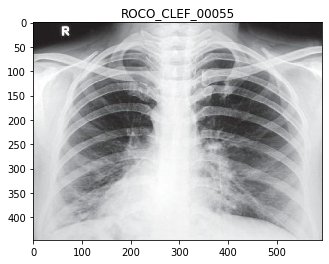

Tag Labebels
 ['C0043299', 'C1548003', 'C0817096', 'C1962945']
Tag names
 ['x-ray procedure', 'radiograph', 'thoracics', 'radiogr'] 

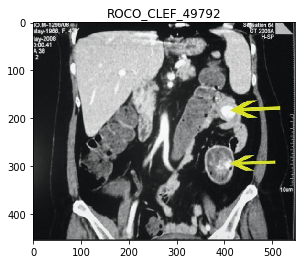

Tag Labebels
 ['C0772294', 'C0022378', 'C0221198']
Tag names
 ['alesion', 'digiuno', 'visible lesion'] 

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for j in [40196,40199]:
  img = mpimg.imread(f"training-set/{train_concepts_pd.loc[j].image}.jpg")
  plt.title(train_concepts_pd.loc[j].image)
  plt.imshow(img)
  plt.show()
  # print the tags and the coresponding names.
  print('Tag Labebels\n',train_concepts_pd.loc[j].tag)
  print('Tag names\n',[string_concepts_pd.loc[string_concepts_pd.tags == i].names.iloc[0] for i in train_concepts_pd.loc[j].tag],end=" ")

In [0]:
# An image can have multiple tags
print([string_concepts_pd.loc[string_concepts_pd.tags==train_concepts_pd.tag[1][x]].names.iloc[0] for x,i in enumerate(train_concepts_pd.tag[1])])

['alesion', 'gastrointestinal tract', 'visible lesion', 'obstetric ultrasounds', 'medical sonography']


#### Source i used

* https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
* https://stackoverflow.com/questions/1157106/remove-all-occurrences-of-a-value-from-a-list
* https://stackoverflow.com/questions/11348347/find-non-common-elements-in-lists
* https://stackoverflow.com/questions/1285468/python-filter-a-list-to-only-leave-objects-that-occur-once


In [8]:
from statistics import mode
print('There are ',len(string_concepts_pd),'unique tags in total')
# for every image we are counting the numbers of tags 
a = train_concepts_pd.tag.apply(lambda x: len(x))
print('Images has at least',min(a),'concept and at most',max(a),'.On average they have',int(sum(a)/len(a)))

flat_list = []
# we store all the image concepts in on array. 
# in every row take every tag and append in an array
for sublist in train_concepts_pd.tag:
    for item in sublist:
        flat_list.append(item)

# looking for the most frequent tag the set.
def frequent(N,f_list):
  common = []
  for i in range(N):
#   for the flat list of tags in the trainning set find the median
    common.append(mode(f_list))
    # delete the median from the flat list in order to find the next most frequent tag
    f_list = list(filter(lambda a: a != common[i], f_list))
  return common
common = frequent(10,flat_list)

There are  5528 unique tags in total
Images has at least 1 concept and at most 72 .On average they have 6


In [9]:
# The names of the 10 most frequent tags in the trainning set and their coresponding occurencies 
names = [string_concepts_pd.loc[string_concepts_pd.tags==x].names.iloc[0] for x in common]
occurencies = [flat_list.count(x) for x in common]
print('10 Most frequent concepts',names,'Number of occurencies',occurencies,sep='\n')
# unused concepts
print("Concepts were not used at all in training set:",len(set(string_concepts_pd)^set(flat_list)))

d = {}
# create a dictonary with keys the tags and values true of false if a tag occured twice
for i in flat_list: d[i] = i in d
# counts all the values that appear once in the dictionary
print('Tags appeared only once in training set:',len([k for k in d if not d[k]]))

10 Most frequent concepts
['diagnostic scanning', 'x-ray procedure', 'radiogr', 'tomogr', 'pantomogr', 'thoracics', 'x-ray computer assisted tomography', 'radiograph', 'visible lesion', 'alesion']
Number of occurencies
[6733, 6321, 6318, 6235, 6127, 5981, 5801, 5159, 4513, 4512]
Concepts were not used at all in training set: 5218
Tags appeared only once in training set: 1530


### Preprocess your data
* Preprocess the images so that you can use them as input.
* You may have to preprocess also the labels.


### Sources i used
* https://github.com/Blaizzy/BiSeNet-Implementation/blob/master/Preprocessing.ipynb
* http://cs231n.github.io/neural-networks-2/#datapre

In [0]:
import numpy as np
# set seed in order to draw every time the same data
np.random.seed(1)
# the size of the dataset (change the portion)
N =int(len(train_concepts_pd)*0.2)
N_val = int(len(train_concepts_pd)*0.2)

# a = np.random.randint(low=0,high=len(train_concepts_pd),size=N)
#in case i want the whole  training set
a = range(len(train_concepts_pd))  
a_v = np.random.randint(low=0,high=len(val_concepts_pd),size=N_val)
# a_v =range(len(val_concepts_pd))

In [0]:
import cv2
# function to store the images in memory
def get_image(N):
  x =[]
  for i in N:
    # store the images in memory in Grayscale (two dimensional arrays)
    x.append(cv2.imread(f"training-set/{train_concepts_pd.loc[i].image}.jpg",cv2.IMREAD_GRAYSCALE))
  return x
train_x = get_image(a)

In [0]:
# function the manualy pre process the images. Scale them in 224x224 size and remove noise with gaussian blur
def processing(x):
  # set the dimension
  height = 224
  width = 224
  dim = (width, height)
  res_img = []
  for i in range(len(x)):
    # resize them .(Interpolation =INTER_AREA is better for size reduction according to documentation of cv2)
    res = cv2.resize(x[i], dim, interpolation=cv2.INTER_AREA)
    res_img.append(res)
  x = []
 
  for i in range(len(res_img)):
    blur = cv2.GaussianBlur(res_img[i], (5, 5), 0)
    x.append(blur)
  return x

train_x = processing(train_x)


In [0]:
import numpy as np

train_y = train_concepts_pd.tag.loc[a]  
val_y = val_concepts_pd.tag.loc[a_v]

def get_onehot (tags, taglist=list(string_concepts_pd.tags)):
    # get the position of the tags in the list of tags
    tag_indices = {taglist.index(tag) for tag in tags}
    # form a list where True are indices of the positions of the tags
    hot_embedding = [int(tag_index in tag_indices) for tag_index in range(len(taglist))]
    return hot_embedding

# transform the dependent variable in one hot embedding and store it in a vector
train_y = np.vstack(train_y.apply(get_onehot))
val_y = np.vstack(val_y.apply(get_onehot))

In [0]:
val_x = []
for i in a_v:
  # fetch the validation images fro the drive and pre process them
    val_x.append(cv2.imread(f"validation-set/{val_concepts_pd.loc[i].image}.jpg",cv2.IMREAD_GRAYSCALE))
val_x = processing(val_x)

In [0]:
# standarize the images.Deduct the mean and devide with standar deviation in order to improve the speed of neural network
#Does not work for the whole dataset  
def me(x):
  x -= np.mean(train_x,axis=0)
  return list(x)
def var(x):
  x /= np.std(train_x,axis=0)
train_x = me(train_x)
# val_x = me(val_x)

In [0]:
# reshape the images in 224x224x1 (neural network requeires a thrid dimension)
def reshape(x):
  e = []
  for i in range(len(x)):
    e.append(np.reshape(x[i], (224, 224, 1)))
  return e
train_x = reshape(train_x)
val_x = reshape(val_x)

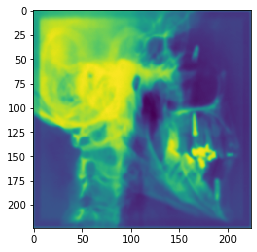

In [0]:
plt.imshow(train_x[3500])
plt.show()

### Build a baseline
* Make a list of frequent concepts and use this list for any image in question.
* You can improve it: choose concepts based on their frequency (the more frequent are more likely to be chosen).

In [0]:
f1 = []
for i in range(8,13):
  # fetch the most frequent tags andstore then in a dataframe
  base_pred = pd.DataFrame({"tags":[frequent(i,flat_list)]*len(a)})
  # apply one hot embeding to the most frequent tag
  y_base = np.vstack(base_pred.tags.apply(get_onehot))
  # compute the f1 score and append it to an array
  f1.append(f1_score(train_y, y_base,average='micro'))

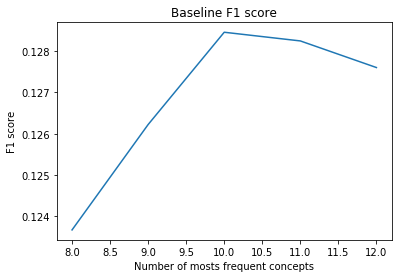

In [25]:
# plot the most frequest tags against the f1 score and choose the highest
plt.plot(range(8,13),f1)
plt.title("Baseline F1 score")
plt.xlabel("Number of mosts frequent concepts")
plt.ylabel("F1 score")
plt.show()

Selecting the 10 most frequent concepts and assign them in every image we achive the best f1 score and use it as baseline

#### Build your system
* You can use any of the systems you have seen in class. Or any other you feel comfortable using.
* Experiment with Neural Networks (use Keras).
* You can try using [pretrained models](https://keras.io/applications/), but there is no free lunch: you might be required to limit your dataset to save memory.

### Source i used
* https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24

In [0]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Dropout
from keras import  optimizers

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',input_shape=(224,224,1)))
model.add(Activation('relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(2764))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5528, activation='sigmoid'))
# rmsprop(lr=0.0001, decay=1e-6)
model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=['accuracy']) 

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, restore_best_weights=True)

history = model.fit(np.array(train_x),np.array(train_y),validation_data=(np.array(val_x),np.array(val_y)), epochs=100, batch_size=32,callbacks=[early_stop])




Train on 56629 samples, validate on 11325 samples
Epoch 1/100





56629/56629 [==============================] - 382s 7ms/step - loss: 0.0221 - acc: 0.9974 - val_loss: 0.0088 - val_acc: 0.9989
Epoch 2/100
56629/56629 [==============================] - 364s 6ms/step - loss: 0.0062 - acc: 0.9989 - val_loss: 0.0062 - val_acc: 0.9989
Epoch 3/100
56629/56629 [==============================] - 363s 6ms/step - loss: 0.0061 - acc: 0.9989 - val_loss: 0.0060 - val_acc: 0.9989
Epoch 4/100
56629/56629 [==============================] - 363s 6ms/step - loss: 0.0060 - acc: 0.9989 - val_loss: 0.0059 - val_acc: 0.9989
Epoch 5/100
56629/56629 [==============================] - 363s 6ms/step - loss: 0.0060 - acc: 0.9989 - val_loss: 0.0059 - val_acc: 0.9989
Epoch 6/100
56629/56629 [==============================] - 363s 6ms/step - loss: 0.0060 - acc: 0.9989 - val_loss: 0.0059 - val_acc: 0.9989
Epoch 7/100
56629/56629 [==============================] - 364s 6ms/step - loss: 0.0060 - acc: 0.9989 - val_

In [0]:
# save the model
from keras.models import load_model

# model.save('model2_07-12.h5')
model = load_model('/content/drive/My Drive/Colab Notebooks/model2_07-12.h5')

In [0]:
def f1(x,n):
  # predict the tags 
  b = model.predict(np.array(x))
  # vectorize every row in order to be stored in DataFrame
  b = [[b[i]] for i in range(len(b))]
  predictions = pd.DataFrame(data=b,index=range(len(b)),columns=['predictions'])
# for every tag above a threshold set 1 and the rest 0
  for i in range(len(predictions)): 
    predictions.predictions[i][predictions.predictions[i]>=n] = 1   
    predictions.predictions[i][predictions.predictions[i]<n] = 0
  return predictions


In [0]:
from sklearn.metrics import *
pred = []
b = model.predict(np.array(val_x))
# compute the f1 score for five thresholds between the minimum and the maximum value 
for i in np.arange(b.min(),b.max(),(b.max()-b.min())/5):
  pred.append(f1(val_x,i))
scores=[]
for i in pred:
  scores.append(f1_score(val_y,np.stack(i.predictions),average="micro"))

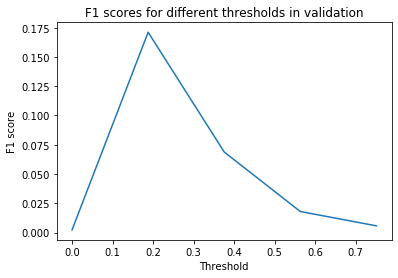

In [0]:
import matplotlib.pyplot as plt
plt.plot(np.arange(b.min(),b.max(),(b.max()-b.min())/5),scores)
plt.title("F1 scores for different thresholds in validation")
plt.xlabel("Threshold")
plt.ylabel("F1 score")
plt.show()

In [0]:
# f1 score in the validation set
f1_score(val_y,np.stack(pred.predictions),average="micro")

0.19846295075793238

In [0]:
# F1 score in the test set
from sklearn.metrics import *
pred = f1(train_x,0.09)
f1_score(train_y,np.stack(pred.predictions),average="micro")

0.2111610313257139

### Assessment
* For each (test) image, measure the F1 of the retrieved tags. You can use the evaluation code of the competition, which can be found in the official site, in the Evaluation Methodology section.
* Calculate the average for all the test images. 

In [0]:
data_id = "1diO2apPPFJeTH8CGcd3S55OUNTXtJVu2"
!gdown --id {data_id}

Downloading...
From: https://drive.google.com/uc?id=1diO2apPPFJeTH8CGcd3S55OUNTXtJVu2
To: /content/ImageCLEF_test-set.zip
708MB [00:10, 67.3MB/s]


In [0]:
!unzip -q ImageCLEF_test-set.zip

In [0]:
import os
image_files = os.listdir("Last/")
image_files[0]

'ROCO_CLEF_TEST_09284.jpg'

In [0]:
test =[]
for i in range(len(image_files)):
  test.append(cv2.imread(f"Last/{image_files[0]}",cv2.IMREAD_GRAYSCALE))

In [ ]:
# preprocess the test set and predict the concepts
test = processing(test)
test =reshape(test)
pre_test = f1(test,0.09)